In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set repository root path and change to it
repo_root_path = '/content/PatchTST'
os.chdir(repo_root_path)
print(f"Working directory: {os.getcwd()}")

# Build clean sys.path with supervised ahead of physics to avoid utils shadowing
supervised_path = os.path.join(repo_root_path, 'PatchTST_supervised')
physics_path = os.path.join(repo_root_path, 'PatchTST_physics_integrated')
new_paths = [p for p in [supervised_path, physics_path, repo_root_path] if p not in sys.path]
sys.path = new_paths + sys.path  # prepend in desired order

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Python path head: {sys.path[:5]}")

# Numpy fix
if not hasattr(np, 'Inf'):
    np.Inf = np.inf
    np.NaN = np.nan
    np.NAN = np.nan
    np.NINF = np.NINF if hasattr(np, 'NINF') else -np.inf
    print("NumPy compatibility patch applied for np.Inf -> np.inf")
else:
    print("NumPy already has np.Inf attribute")

Working directory: /content/PatchTST
PyTorch Version: 2.8.0+cu126
CUDA Available: True
Python path head: ['/content/PatchTST/PatchTST_supervised', '/content/PatchTST/PatchTST_physics_integrated', '/content/PatchTST', '/', '/env/python']
NumPy compatibility patch applied for np.Inf -> np.inf


## 1. Import Physics-Integrated PatchTST Modules

In [2]:
from PatchTST_physics_integrated.config import PhysicsIntegratedConfig
from PatchTST_physics_integrated.models import PhysicsIntegratedPatchTST
from PatchTST_physics_integrated.training_utils import set_seed, get_target_indices, get_scheduler
from PatchTST_physics_integrated.trainer import train_model
from PatchTST_physics_integrated.evaluation import evaluate_model, evaluate_per_channel
from PatchTST_physics_integrated.data_preprocessing import add_hour_of_day_features

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 2. Load Configuration

In [3]:
# Create configuration
args = PhysicsIntegratedConfig()
set_seed(args.random_seed)

# Have low patience for trying attempts
args.patience = 3

# Print configuration
print("\nConfiguration:")
print(f"  Input channels: {args.enc_in}")
print(f"  Output channels: {args.c_out}")
print(f"  Sequence length: {args.seq_len}")
print(f"  Prediction length: {args.pred_len}")
print(f"  Batch size: {args.batch_size}")
print(f"  Learning rate: {args.learning_rate}")
print(f"  Patience: {args.patience}")
print(f"\nChannel Groups (sources → targets):")
for name, group in args.channel_groups.items():
    indices = group['indices']
    src_names = group.get('names', [])
    output_indices = set(group.get('output_indices', []))
    # Map output indices to names using the indices ordering
    tgt_names = [src_names[i] for i, idx in enumerate(indices) if idx in output_indices] if src_names else []
    print(f"  {name}:")
    if src_names:
        print(f"    Sources: {', '.join(src_names)}")
    else:
        print(f"    Sources: (names not provided)")
    if tgt_names:
        print(f"    Targets: {', '.join(tgt_names)}")
    else:
        print(f"    Targets: (names not provided)")

Random seed set to: 42

Configuration:
  Input channels: 23
  Output channels: 23
  Sequence length: 512
  Prediction length: 336
  Batch size: 64
  Learning rate: 0.0001
  Patience: 3

Channel Groups (sources → targets):
  long_channel:
    Sources: p (mbar), T (degC), Tpot (K), rh (%), VPmax (mbar), VPact (mbar), VPdef (mbar), wv (m/s), max. wv (m/s), wd (deg), rain (mm), raining (s), sh (g/kg), H2OC (mmol/mol), rho (g/m**3), Tdew (degC), Tlog (degC), CO2 (ppm), PAR (umol/m2/s), Tmax (degC), Tmin (degC), hour_sin, hour_cos
    Targets: T (degC), Tpot (K), wv (m/s), rain (mm)
  short_channel:
    Sources: p (mbar), T (degC), Tpot (K), rh (%), VPmax (mbar), VPact (mbar), VPdef (mbar), wv (m/s), max. wv (m/s), wd (deg), rain (mm), raining (s), sh (g/kg), H2OC (mmol/mol), rho (g/m**3), Tdew (degC), Tlog (degC), CO2 (ppm), PAR (umol/m2/s), Tmax (degC), Tmin (degC), hour_sin, hour_cos
    Targets: max. wv (m/s), raining (s), Tdew (degC)


## 3. Preprocess Data (Add Hour Features)

In [4]:
# Add hour-of-day features to dataset
original_path = os.path.join(args.root_path, 'weather.csv')
enhanced_path = os.path.join(args.root_path, args.data_path)

df_enhanced = add_hour_of_day_features(original_path, enhanced_path)

Loading original dataset from: ./datasets/weather/weather.csv
Original shape: (52696, 22)
Original columns: ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT']

New shape: (52696, 24)
New columns: ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT', 'hour_sin', 'hour_cos']

Hour feature statistics:
           hour_sin      hour_cos
count  52696.000000  5.269600e+04
mean      -0.000070  1.437736e-04
std        0.707146  7.070808e-01
min       -1.000000 -1.000000e+00
25%    

## 4. Load Data (Using PatchTST Data Providers)

In [5]:
# Change to PatchTST_supervised directory for data_provider imports
import importlib

os.chdir(os.path.join(repo_root_path, 'PatchTST_supervised'))
print(f"Changed to: {os.getcwd()}")

# Clear cached modules to avoid stale 'utils' shadowing
for m in [
    'utils', 'utils.timefeatures',
    'data_provider', 'data_provider.data_loader', 'data_provider.data_factory'
]:
    if m in sys.modules:
        sys.modules.pop(m, None)

from data_provider.data_factory import data_provider

os.chdir(repo_root_path)

# Create data loaders
train_data, train_loader = data_provider(args, 'train')
val_data, val_loader = data_provider(args, 'val')
test_data, test_loader = data_provider(args, 'test')

print(f"\nData loaded:")
print(f"  Train samples: {len(train_data)}")
print(f"  Val samples: {len(val_data)}")
print(f"  Test samples: {len(test_data)}")

Changed to: /content/PatchTST/PatchTST_supervised
train 36040
val 4935
train 36040
val 4935
test 10204

Data loaded:
  Train samples: 36040
  Val samples: 4935
  Test samples: 10204
test 10204

Data loaded:
  Train samples: 36040
  Val samples: 4935
  Test samples: 10204


## 5. Create Model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = PhysicsIntegratedPatchTST(args).float().to(device)

# Get target indices and names
target_indices, target_names = get_target_indices(args.channel_groups)

print(f"\nModel created:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("  Target variables by group:")
for group, info in args.channel_groups.items():
    output_indices = set(info.get('output_indices', []))
    src_names = info.get('names', [])
    tgt_names = [src_names[i] for i, idx in enumerate(info['indices']) if idx in output_indices] if src_names else []
    print(f"    {group}: {', '.join(tgt_names) if tgt_names else '(names not provided)'}")

Using device: cuda

Model created:
  Total parameters: 26,102,562
  Target variables by group:
    long_channel: T (degC), Tpot (K), wv (m/s), rain (mm)
    short_channel: max. wv (m/s), raining (s), Tdew (degC)

Model created:
  Total parameters: 26,102,562
  Target variables by group:
    long_channel: T (degC), Tpot (K), wv (m/s), rain (mm)
    short_channel: max. wv (m/s), raining (s), Tdew (degC)


In [7]:
# Inspect full model architecture
print("\nModel architecture:\n")
print(model)



Model architecture:

PhysicsIntegratedPatchTST(
  (revin_layer): RevIN()
  (encoders): ModuleDict(
    (long_channel): PerChannelEncoder(
      (padding_layer): ReplicationPad1d((0, 12))
      (W_P): Linear(in_features=24, out_features=128, bias=True)
      (attentions): ModuleList(
        (0-22): 23 x CustomMultiheadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=True)
          (sdp_attn): _ScaledDotProductAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
          )
          (to_out): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): GELU(approximate='none')
            (4): Linear(in_features=512, out_features=128, bias=True)
          )


## 6. Setup Training

In [8]:
# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=1e-4)

# Create scheduler (OneCycleLR as in baseline notebook)
train_steps = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    steps_per_epoch=train_steps,
    pct_start=args.pct_start,
    epochs=args.train_epochs,
    max_lr=args.learning_rate
)

# Create loss function
criterion = nn.MSELoss()

# Create checkpoint directory
checkpoint_path = args.checkpoints
os.makedirs(checkpoint_path, exist_ok=True)

print("Training setup complete")

Training setup complete


## 7. Train Model

In [9]:
import time

# Train the model
start_time = time.time()
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    args=args,
    device=device,
    target_indices=target_indices,
    checkpoint_path=checkpoint_path
)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


Starting Physics-Integrated PatchTST Training...
Checkpoint path: ./checkpoints_physics_integrated
Input channels: 23 (21 weather + 2 hour)
Output channels: 23 (21 weather only)
──────────────────────────────────────────────────────────────────────
Physics Groups (with integrated hour features):
  long_channel: 4 weather + hour → patch=24 , stride=12
  short_channel: 3 weather + hour → patch=6 , stride=6

Epoch 1/100 | Time: 165.30s
  Train Loss: 0.5968102 | Val Loss: 0.5773093 | Test Loss: 0.3342895
  Epoch duration: 165.30 seconds
  Target Variable Losses:
    Long: 0.4304911
    Short: 0.8185691
Validation loss decreased (inf --> 0.577309). Saving model ...

Epoch 1/100 | Time: 165.30s
  Train Loss: 0.5968102 | Val Loss: 0.5773093 | Test Loss: 0.3342895
  Epoch duration: 165.30 seconds
  Target Variable Losses:
    Long: 0.4304911
    Short: 0.8185691
Validation loss decreased (inf --> 0.577309). Saving model ...

Epoch 2/100 | Time: 165.93s
  Train Loss: 0.5379978 | Val Loss: 0.56

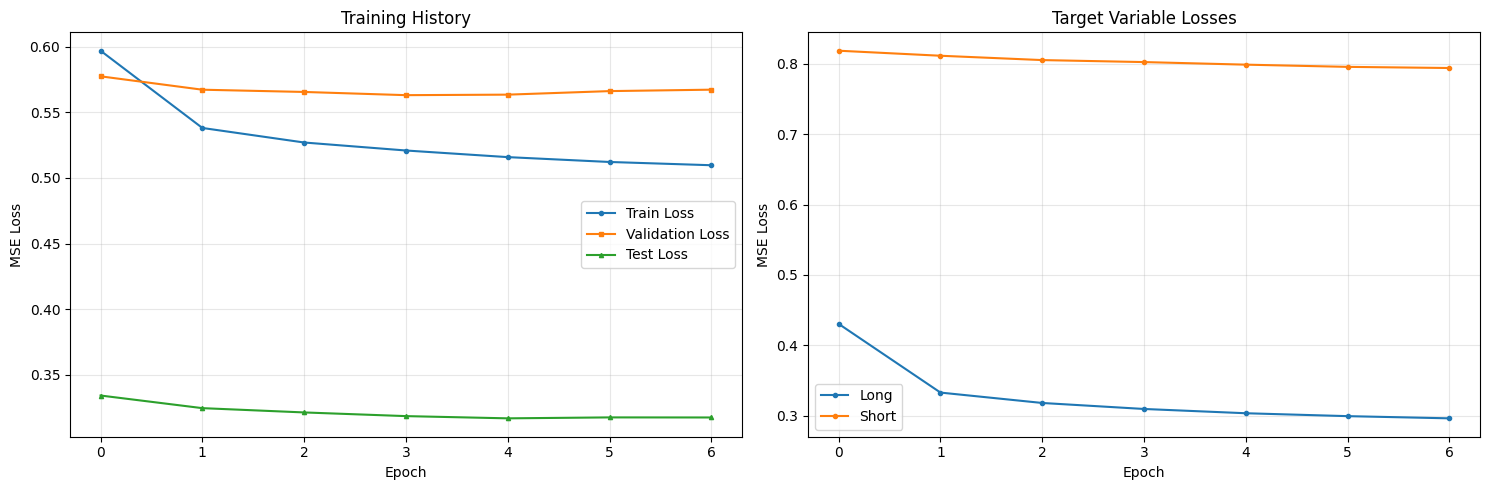

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall losses
axes[0].plot(history['train_losses'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history['val_losses'], label='Validation Loss', marker='s', markersize=3)
axes[0].plot(history['test_losses'], label='Test Loss', marker='^', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Target variable losses
for target_name, losses in history['target_variable_losses'].items():
    axes[1].plot(losses, label=target_name.capitalize(), marker='o', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].set_title('Target Variable Losses')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Evaluate Model

In [11]:
# Evaluate on test set
results = evaluate_model(model, test_loader, device, args)

# Get per-channel metrics
per_channel_metrics = evaluate_per_channel(
    results['preds'],
    results['trues'],
    target_indices,
    target_names
)

print("\nPer-Channel Metrics:")
for ch_name, metrics in per_channel_metrics.items():
    print(f"  {ch_name}:")
    print(f"    MSE: {metrics['mse']:.7f}")
    print(f"    MAE: {metrics['mae']:.7f}")
    print(f"    RMSE: {metrics['rmse']:.7f}")

Evaluation complete:
  Predictions shape: (10176, 336, 7)
  Ground truth shape: (10176, 336, 7)
  Inputs shape: (10176, 512, 7)

Overall Test Metrics:
  MSE: 0.3186072
  MAE: 0.3005293
  RMSE: 0.5644530
  MAPE: 250.92%
  Correlation: 0.7175

Per-Channel Metrics:
  rain (mm):
    MSE: 0.3231136
    MAE: 0.4155630
    RMSE: 0.5684308
  T (degC):
    MSE: 0.2085487
    MAE: 0.3357341
    RMSE: 0.4566714
  Tpot (K):
    MSE: 0.2710769
    MAE: 0.3762854
    RMSE: 0.5206504
  wv (m/s):
    MSE: 0.0743482
    MAE: 0.1940850
    RMSE: 0.2726686
  raining (s):
    MSE: 0.0007583
    MAE: 0.0215839
    RMSE: 0.0275377
  Tdew (degC):
    MSE: 1.0725086
    MAE: 0.3656070
    RMSE: 1.0356199
  max. wv (m/s):
    MSE: 0.2798976
    MAE: 0.3948439
    RMSE: 0.5290535

Overall Test Metrics:
  MSE: 0.3186072
  MAE: 0.3005293
  RMSE: 0.5644530
  MAPE: 250.92%
  Correlation: 0.7175

Per-Channel Metrics:
  rain (mm):
    MSE: 0.3231136
    MAE: 0.4155630
    RMSE: 0.5684308
  T (degC):
    MSE: 0.208548

## 10. Visualize Predictions

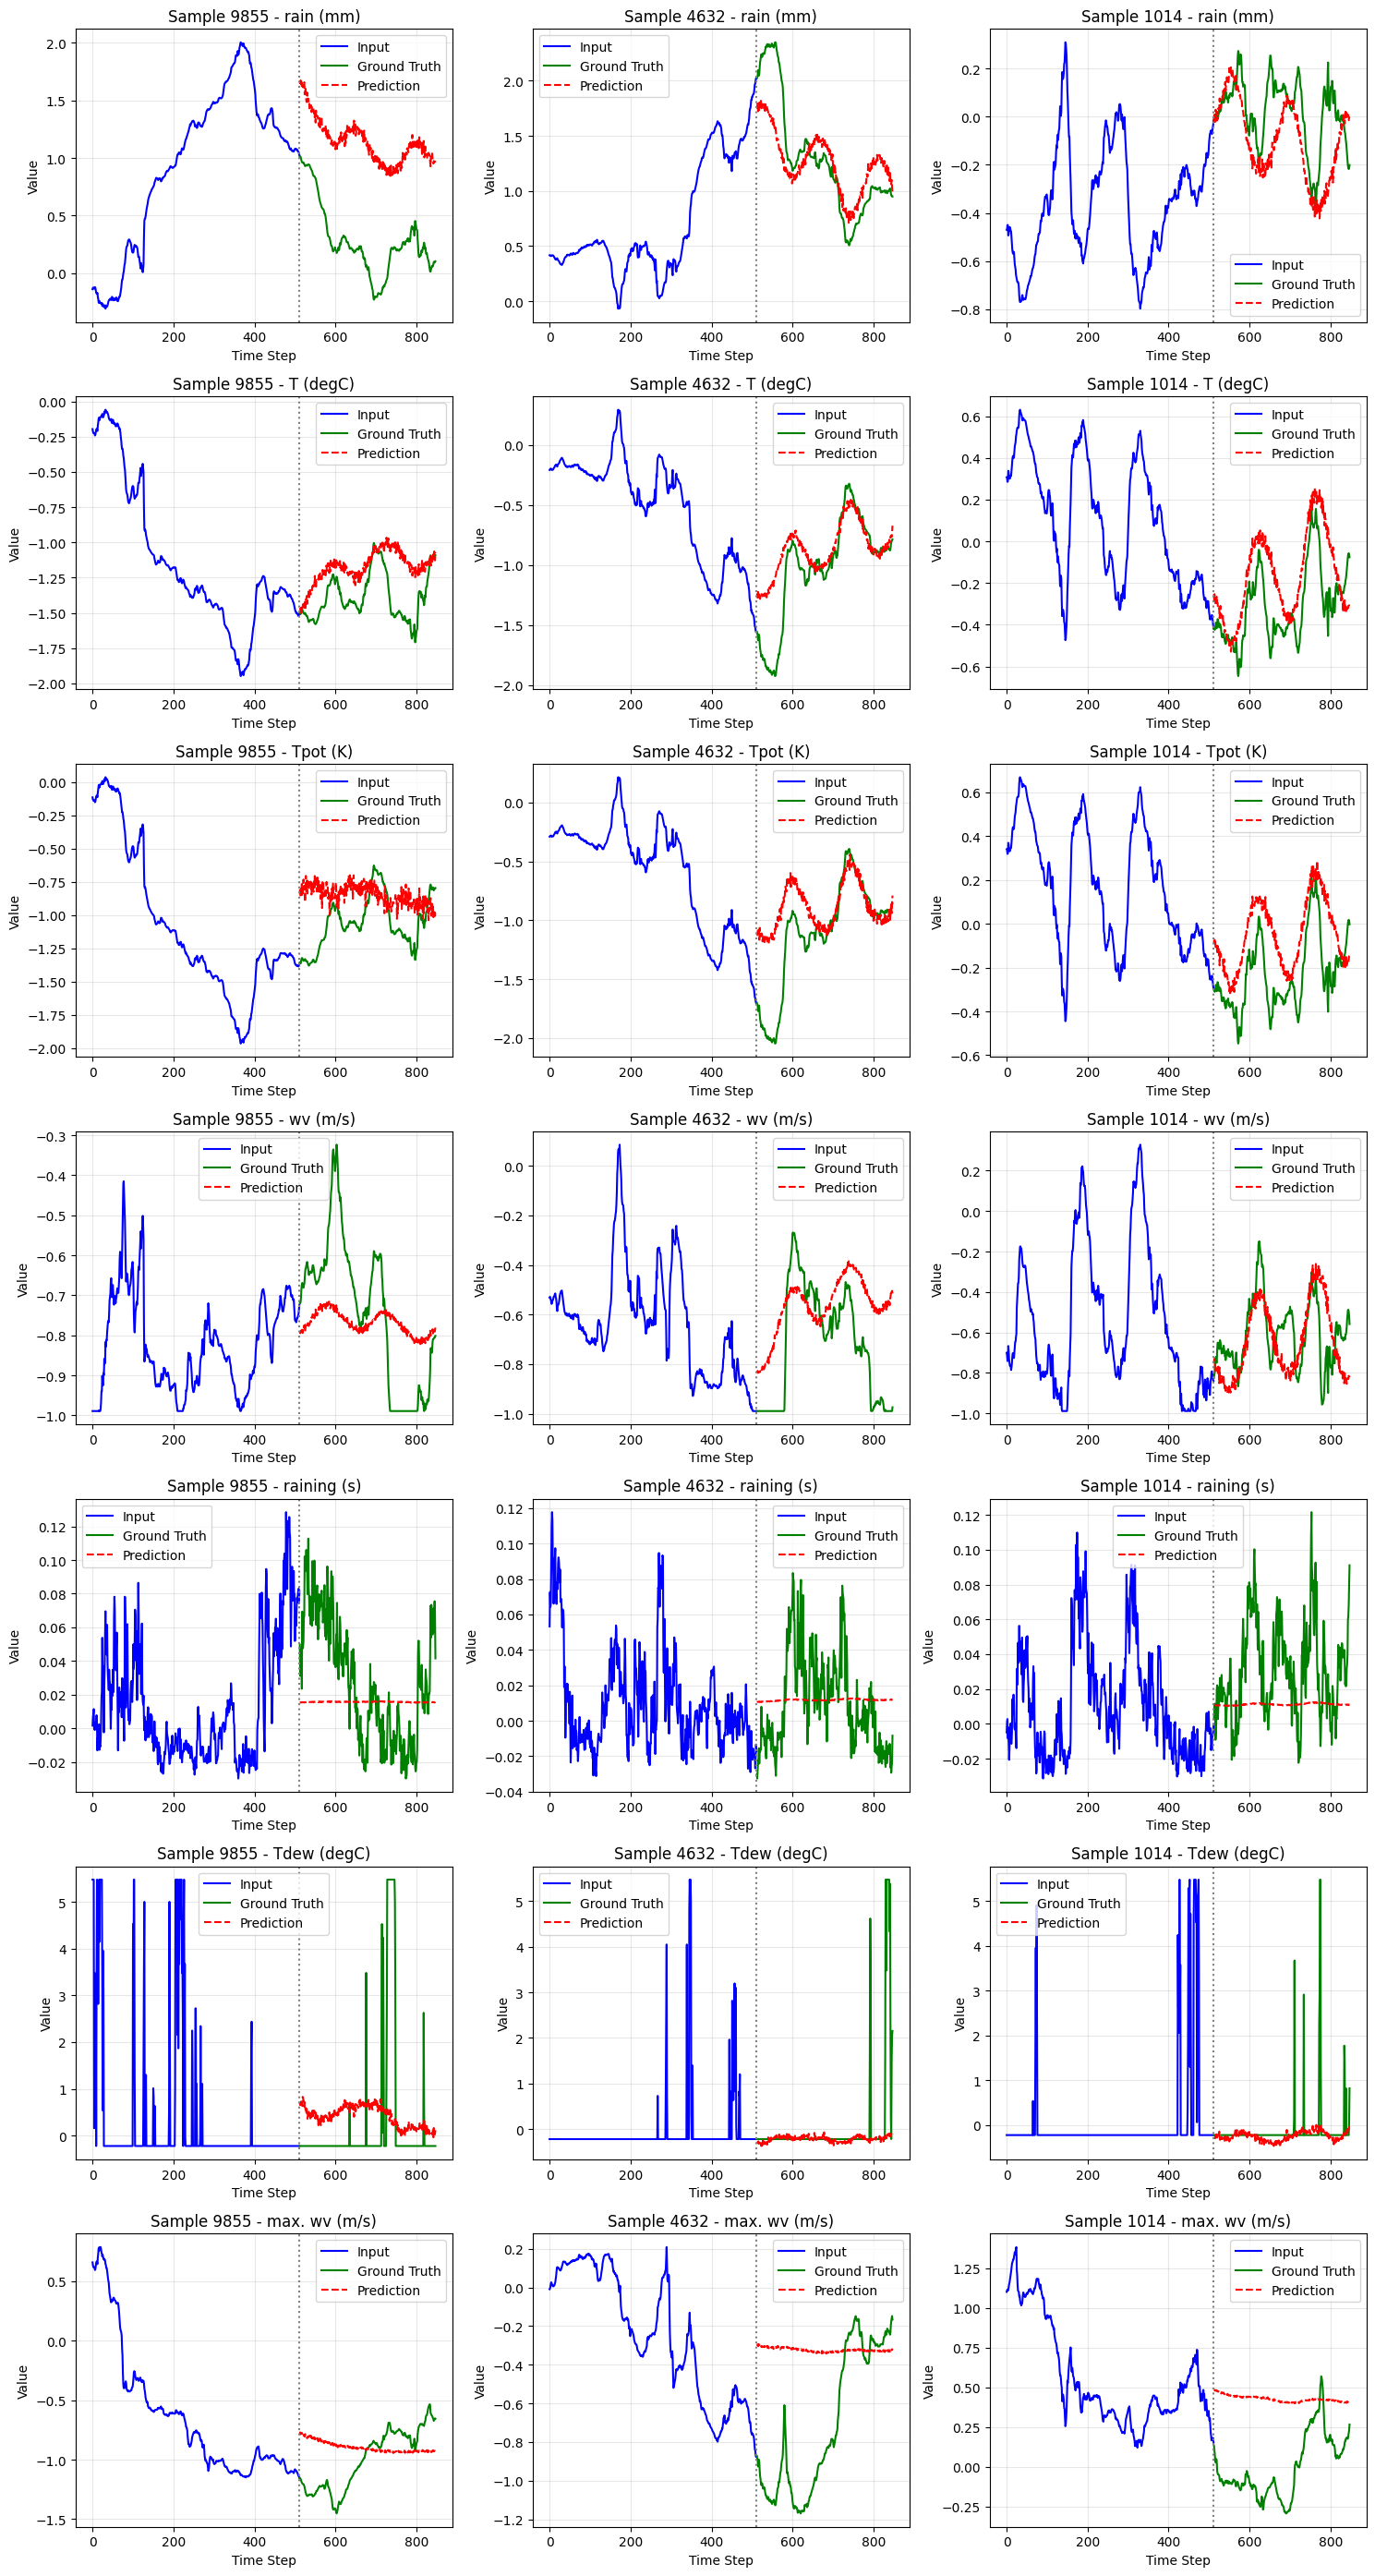

Chart saved to: /content/PatchTST/OutputCharts/prediction_visualization_20251209_053755.png


In [13]:
# Plot predictions for target variables with random sample selection
%matplotlib inline
import datetime
import os

num_samples = 3
num_available = results['preds'].shape[0]

# Choose random distinct sample indices to visualize
sample_indices = np.random.choice(num_available, size=min(num_samples, num_available), replace=False)

fig, axes = plt.subplots(len(target_indices), len(sample_indices), figsize=(5*len(sample_indices), 4*len(target_indices)))
if len(sample_indices) == 1:
    axes = axes.reshape(-1, 1)

# Note: results['preds'], results['trues'], and results['inputs'] are already filtered to target channels
# So we use index 'i' (0, 1, 2, ...) not 'ch_idx' (original channel indices like 10, 1, 2, ...)
for i, ch_name in enumerate(target_names):
    for col, sample_idx in enumerate(sample_indices):
        input_seq = results['inputs'][sample_idx, :, i]
        true_seq = results['trues'][sample_idx, :, i]
        pred_seq = results['preds'][sample_idx, :, i]

        input_steps = np.arange(len(input_seq))
        pred_steps = np.arange(len(input_seq), len(input_seq) + len(pred_seq))

        ax = axes[i, col]
        ax.plot(input_steps, input_seq, 'b-', label='Input')
        ax.plot(pred_steps, true_seq, 'g-', label='Ground Truth')
        ax.plot(pred_steps, pred_seq, 'r--', label='Prediction')
        ax.axvline(x=len(input_seq)-1, color='gray', linestyle=':', linewidth=1.5)
        ax.set_title(f'Sample {sample_idx} - {ch_name}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the chart with datetime filename
output_dir = os.path.join(repo_root_path, 'OutputCharts')
os.makedirs(output_dir, exist_ok=True)

# Create filename with current datetime
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'prediction_visualization_{timestamp}.png'
filepath = os.path.join(output_dir, filename)

fig.savefig(filepath, dpi=300, bbox_inches='tight')
print(f"Chart saved to: {filepath}")
